<a href="https://colab.research.google.com/github/inandout-kr/timeSeriesAnalysis/blob/main/ML_for_time-series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cesium

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# **ML for Time Series 시계열을 위한 머신러닝**

Clustering과 tree based method로 predict와 classification 문제를 다룬다.

시계열의 특징 생성은 tree based method에서 반드시 필요한 과정이다. 앞서 공부했던 ARIMA 모델과는 달리 '시간을 인식'하는 방법론이 아니기 때문이다.

Clustering, 거리 기반 classification은 input으로 원본 시계열이나 특징을 사용할 수 있다.

시계열 자체를 input으로 사용하려면, dynamic time warping(DTW, 동적시간워핑)이라는 거리 평가 지표를 알아야 한다.

시계열에 직접적으로 적용되는 동적시간워핑은 데이터 전체에 대한 시간 정보를 보존한다. 제한된 특징 목록을 사용하는 방법과는 다르다.

## **1. 시계열 분류**
- Electroencephalogram(EEG, 원시 뇌전도) 시계열 데이터에 대한 특징을 만드는 예
    - 머신러닝 알고리즘에 사용
- EEG 시계열 특징 추출 후, decision tree(결정 트리) 기법으로 EEG 데이터 분류

### **1.1 특징의 선택과 생성**
- cesium 패키지로 특징 생성
    - 장점 중 한 가지는, 여러 가지 유용한 데이터셋을 제공한다는 점

데이터셋에 다섯 종류의 EEG 시게열이 존재하고, 각 시계열은 모두 길이가 다르다.

In [ ]:
# cesium 함수 사용해 데이터셋 다운로드
from cesium import datasets
eeg = datasets.fetch_andrzejak()

In [ ]:
type(eeg)

dict

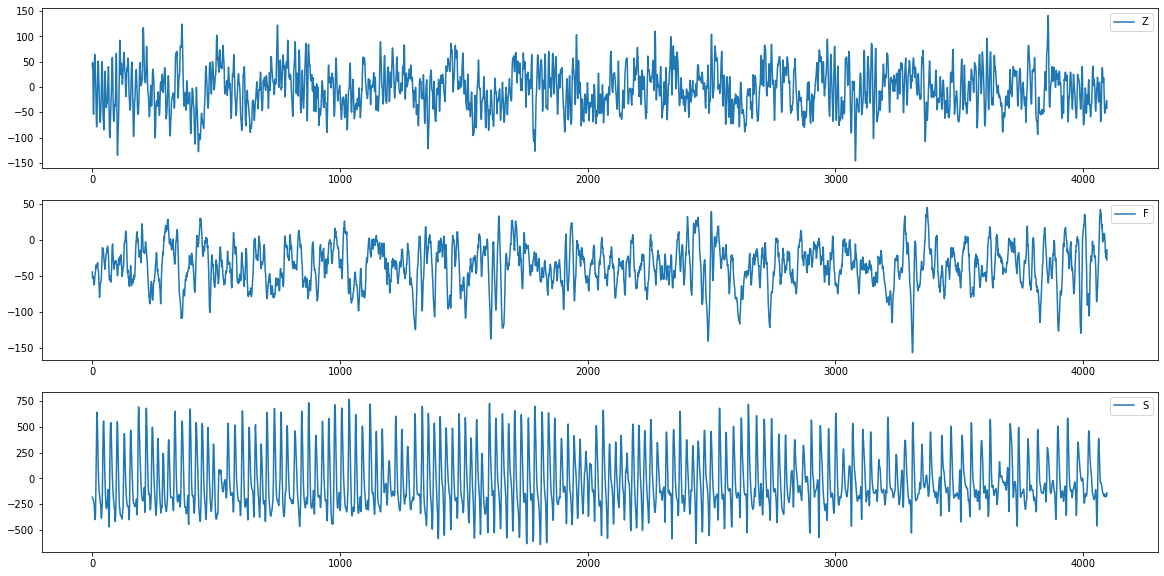

In [ ]:
# 샘플 확인
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [ ]:
type(eeg["measurements"][0])

numpy.ndarray

In [ ]:
type(eeg)

dict

In [ ]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [ ]:
type(eeg['measurements'])

list

In [ ]:
len(eeg['measurements'])

500

In [ ]:
eeg['measurements'][0].shape

(4097,)

EEG 데이터셋 중 임의로 선택된 세 개의 표본에 대한 그래프.

건강한 사람과 간질 환자를 대상으로 서로 다른 두뇌 활동을 측정한 것. 서로 독립적이다.

이는 특징 생성에 대한 가이드를 제공한다. 

가령 Z와 F는 S보다 덜 편향된 것으로 보이고, y축을 보면 각 범주는 꽤 다른 범위의 값으로 구성되었다.
- 진폭이 유용할 수 있다는 것을 시사
- 단지 진폭 뿐이 아니라, 서로 다른 특성을 지닌 것으로 보이는 데이터의 전반적인 분포도 유용


#### cesium으로 특징을 생성하는 방법

In [ ]:
from cesium import featurize as ft
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                  "skew",
                  "max_slope"]
fset_cesium = ft.featurize_time_series(times=eeg["times"],
                                              values=eeg["measurements"],
                                              errors=None,
                                              features_to_use=features_to_use,
                                             scheduler = None)

In [ ]:
fset_cesium

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153
...,...,...,...,...,...
495,876.5,0.368318,0.364413,-0.472757,94242.711864
496,433.0,0.361728,0.394923,0.046880,27595.932203
497,1359.0,0.270442,0.628265,-0.468130,243156.610169


*정규화되지 않은 값이 많다는 사실 유의(일부 기법은 정규화된 input을 가정)

- 오류 검사와 상식적인 확인의 한 예로, 시계열 샘플의 percent_beyond_1_std 확인 가능

In [ ]:
std = np.std(eeg['measurements'][0])
std

40.41100040099819

In [ ]:
mean = np.mean(eeg['measurements'][0])
mean

-4.1320478398828415

In [ ]:
sample_ts = eeg['measurements'][0]
sz = len(sample_ts)
ll = mean - std
ul = mean + std
quals = [i for i in range(sz) if sample_ts[i] < ll or
         sample_ts[i] > ul]

len(quals) / sz

0.3273126678057115

In [ ]:
fset_cesium.iloc[0, 1]

0.3273126678057115

특징 생성 라이브러리를 과하기 사용하지 말자.

자신만의 특징 생성용 코드를 작성해두자.

패키지가 제공할 수 없는 코드의 최적화가 가능하기 때문.

가령 시계열의 평균에 의존적인 여러 특징이 있다면, 평균을 매번 계산하기보다 한 번만 계산하는 코드를 작성할 수 있음.

### **1.2 결정 트리 기법**

한 번에 한 단계씩, 비선형적인 방식으로 결정

한 번에 한 단계씩, 한 변수가 결정에 미치는 미치는 영향력을 생각하는 과정 반복

* 결정 트리에 대해 잘 모른다면, 참고: https://perma.cc/G9AA-ANEN (https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052)

#### **1.2.1 랜덤포레스트**
- 하나가 아닌, 여러 개의 결정 트리 사용
- 분류 혹은 회귀의 결과는 각 트리가 내놓은 출력의 평균을 사용
- 여러 간단한 결정 트리 모델을 합쳐 '군중의 지혜' 효과 기대(단 하나의 최고의 모델을 찾는 대산, 여러 모델 무리를 앙상블하여 예측)
- 랜덤포레스트는 학습될 트리의 개수, 각 트리에 허용되는 최대 깊이에 대한 파라미터에 따라 구조가 결정됨
  - 각 개별 트리는 임의로 선정된 데이터 표본과 특징으로 학습됨
  - 각 트리는 과적합을 피할 수 있도록 꽤 간단한 파라미터로 구성하는 것이 일반적
  - 일반화된 여러 모델이 협력해 평균 도출
  - 충분히 일반화된 결과 도출 가능


각 시계열 샘플의 계산된 특징을 모델에 입력.

원시 시계열 데이터는 다음의 잠재적인 문제를 가지고 있음
- 균일하지 않은 길이의 시계열을 다루는 건 복잡함
- (시간 단계의 개수와 동등한 수준의) 대규모 입력은 계산 비용이 비싼 모델과 학습 과정의 결과를 초래
- (모든 시간 단계는 한 특징으로 매핑되기 때문에) 특정 시간 단계가 매우 중요하지 않다고 가정하면, 트리 관점에서는 시간 단계를 개별 입력으로 봐서 **매우 심한 노이즈**와 **약한 신호**만 존재

따라서 원시 시계열 데이터로 작업할 때, 랜덤포레스트가 좋은 도구는 아님. 그러나 원시 데이터가 특징들로 압축되어 요약되면 매우 유용할 수 있다.





- 유용성을 뒷받침하는 구체적인 이유
  - 효율성/계산 자원 관점에서, 매우 긴 시계열을 소수의 특징으로 추출하고 의미 있는 정확도를 가진 모델을 찾을 수 있다는 건 훌륭하다.
  - 랜덤포레스트는 과적합의 위험을 줄이는 데 좋다. 고의적으로 단순한 방법을 사용하면 이런 우려의 일부를 해결할 수 있다.
  - 랜덤포레스트는 process의 기본 동작에 대해 작동하는 모델이나, 가설이 없는 시계열 데이터에 특히 적합할 수 있다.

**일반적으로 랜덤포레스트는 시계열 예측보다 시계열 분류에서 더 많은 성공을 거두었다.**

#### **1.2.2 그레이디언트 부스팅 트리**
- Boosting은 모델들의 앙상블을 구축하는 또 다른 방법
- 차례대로 생성되는 모델 중, 나중에 생성되는 모델이 이전 모델의 실수를 바로잡는 방향을 가짐
  - 즉 이전 모델에서 잘못 적합된 데이터는 나중 모델에서 더 큰 가중치를 가지게 되는 방식



**XGBoost**는 트리를 차례대로 만든다. 이때 각 트리는 이전 트리들의 결합에 대한 잔차를 예측한다.

가령 XGBoost로 구축된 첫 번째 트리는 데이터와 일치하려고 시도하고, 두 번째 트리는 참값(target)에서 예측된 값을 뺀 **잔차**를 예측한다. 세 번째 트리는 참값에서 첫 번째 트리가 예측한 값, 첫 번째 트리의 잔차에 대해 두 번째 트리가 예측한 값을 뺀 것을 예측한다.


------------------
#### **예제 code**
앞서 생성한 특징을 기반으로 랜덤포레스트와 그레이디언트 부스팅 트리 모델을 모두 학습시켜서 EEG 데이터를 분류한다.

In [ ]:
# 학습용, 테스트용 데이터셋 분리
from sklearn.model_selection import train_test_split  # 혼공머신 Ch.2에서도 나왔던 것
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg['classes'], random_state=21)

In [ ]:
fset_cesium.values

array([[ 1.43500000e+02,  3.27312668e-01,  5.05003661e-01,
         3.28049964e-02,  1.11077966e+04],
       [ 2.11500000e+02,  2.90212351e-01,  6.40468636e-01,
        -9.27149921e-02,  2.06535593e+04],
       [ 1.65000000e+02,  3.02660483e-01,  5.15987308e-01,
        -4.09990842e-03,  1.35376271e+04],
       ...,
       [ 1.35900000e+03,  2.70441787e-01,  6.28264584e-01,
        -4.68130248e-01,  2.43156610e+05],
       [ 1.59000000e+03,  3.05589456e-01,  4.89138394e-01,
        -6.74033914e-01,  1.76856949e+05],
       [ 1.39600000e+03,  2.25774957e-01,  6.06785453e-01,
        -1.34775823e+00,  1.31037288e+05]])

In [ ]:
eeg['classes']

array(['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [ ]:
X_train

array([[ 1.06750000e+03,  2.97778863e-01,  5.87503051e-01,
        -6.26535406e-03,  1.01705763e+05],
       [ 1.83500000e+02,  2.49938980e-01,  6.09714425e-01,
        -9.37163974e-01,  1.18020339e+04],
       [ 2.25000000e+02,  3.15596778e-01,  5.30388089e-01,
        -1.15128193e-01,  1.38847458e+04],
       ...,
       [ 8.95000000e+01,  3.15108616e-01,  5.25018306e-01,
        -2.69978337e-01,  5.55389831e+03],
       [ 9.40000000e+01,  3.08762509e-01,  5.15255065e-01,
        -1.85895885e-01,  3.29762712e+03],
       [ 3.75500000e+02,  3.19257994e-01,  4.91335123e-01,
        -1.47063561e-01,  2.18684746e+04]])

In [ ]:
y_train

array(['S', 'N', 'O', 'F', 'F', 'Z', 'N', 'Z', 'O', 'O', 'O', 'O', 'N',
       'F', 'N', 'O', 'S', 'F', 'Z', 'S', 'O', 'S', 'F', 'O', 'N', 'Z',
       'O', 'S', 'N', 'Z', 'O', 'N', 'F', 'F', 'S', 'Z', 'F', 'O', 'Z',
       'O', 'S', 'Z', 'O', 'Z', 'N', 'S', 'Z', 'O', 'N', 'F', 'O', 'Z',
       'O', 'S', 'O', 'O', 'O', 'O', 'S', 'F', 'O', 'S', 'F', 'F', 'S',
       'Z', 'N', 'Z', 'F', 'S', 'F', 'S', 'S', 'S', 'Z', 'Z', 'O', 'F',
       'S', 'Z', 'O', 'Z', 'O', 'Z', 'N', 'F', 'Z', 'Z', 'Z', 'F', 'F',
       'Z', 'F', 'F', 'O', 'O', 'O', 'O', 'N', 'O', 'S', 'F', 'Z', 'N',
       'F', 'O', 'O', 'F', 'N', 'O', 'F', 'N', 'F', 'F', 'S', 'S', 'S',
       'N', 'F', 'S', 'O', 'S', 'O', 'F', 'F', 'F', 'F', 'O', 'S', 'S',
       'S', 'S', 'F', 'Z', 'N', 'O', 'O', 'Z', 'Z', 'Z', 'Z', 'O', 'N',
       'Z', 'Z', 'Z', 'N', 'N', 'F', 'Z', 'O', 'O', 'Z', 'S', 'O', 'N',
       'O', 'Z', 'Z', 'F', 'Z', 'N', 'Z', 'F', 'Z', 'Z', 'N', 'N', 'S',
       'F', 'S', 'O', 'F', 'F', 'O', 'O', 'S', 'N', 'F', 'O', 'F

In [ ]:
# 랜덤포레스트를 사용해 EEG 데이터를 분류하는 모델 생성
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth = 3,
                                random_state = 21)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [ ]:
# score method로 학습에 사용되지 않은 테스트 데이터셋에 대한 정확도 결정
rf_clf.score(X_test, y_test)

0.616

약간의 코드 작성으로 (의학에 대해 모르는) 사람이 직접 분류하는 것보다 더 나은 모델을 만들었다. 이 모델은 전체 EEG 데이터 대산, 요약 통계를 입력으로 사용한 것으로, 좋은 특징이 선택된 덕분이라는 것을 기억하자.

In [ ]:
# XGBoost
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                            max_depth = 3,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.648

In [ ]:
# 모델 학습에 소요된 시간 계산
start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
print(f'XGBoost 학습 소요 시간: {end - start}')

start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
print(f'Random Forest 학습 소요 시간: {end - start}')

XGBoost 학습 소요 시간: 0.05382132530212402
Random Forest 학습 소요 시간: 0.02911376953125


(일반적으로 XHBoost가 더 짧게 걸린다고 하는데.. 여긴 반대로 나와 있음. 그러나 상기 코드는 성능 테스트를 수행하는 방법이 아니라는 점을 인지하자.)

-------------------------------
두 앙상블에 대해 통일한 트리 개수를 부여하고, 트리들의 깊이를 제한해서 복잡도를 낮춘 경우.

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                            max_depth = 1,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.score(X_test, y_test))


from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth = 1,
                                random_state = 21)
rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

0.632
0.376


- 이유
  - 분류 작업에 선택된 모든 특징들이 유용하지는 않을 수 있음
  - 부스팅은 항상 모든 특징을 사용하고, 관련도가 높은 것에 특혜를 줘서 의미 없는 특징이 무시될 가능성이 높음
  - 배깅(랜덤포레스트)은 덜 의미 있는 특징을 사용하도록 강요 받을 수 있음
  - 때문에 현실적으로 점검 불가능한 수준으로, 수백 개에 달하는 시계열의 특징을 생성할 때, 부스팅은 최악의 결과에 대한 일종의 안전 장치가 될 수 있다.


-----------------------
여러 통계학자는 예측에 있어서 머신러닝이 전통적인 통계 분석보다 덜 성공했다고 주장한다. 그러나 그레이디언트 부스팅 트리가 등장한 이래로, 큰 데이터가 주어질 때 머신러닝이 전통적인 통계 모델의 성능을 앞지른 경우를 많이 볼 수 있다.

그레이디언트 부스팅 트리 모델의 한 가지 장점은 **'자율적으로'** 접근하는 능력을 가졌다는 것이다.

즉 모델이 스스로 관련성이 적거나 노이즈가 많은 특징은 제거하고, 가장 중요한 특징들에 초점을 맞춘다는 것이다.

그러나 아무리 좋아봐야 input 데이터를 뛰어넘을 수는 없다.

모델을 향상시키기 위한 가장 중요한 벙법은 **검증된 고품질 input 특징**을 제공하는 것이다.




- **모델을 향상하는 여러 방법**
  - XGBoost 옵션으로 생성 가능한 특징 중 **요도** 이용
    - 특징의 유용성 파악에 도움
    - 유용하다고 판단된 특징과 유사한 특징을 추가하는 방식으로 데이터셋 확장 가능
  - 하이퍼파라미터 격자 탐색으로 모델 파라미터 조정
  - 원시 시계열의 잘못 레이블링된 데이터 찾아보고, 현재 모델에 사용된 특징으로 표현 가능한지 확인
    - 잘못 레이블링된 데이터를 보다 잘 묘사하는 특징을 추가해, input을 보강
  


-------------------------------------------------

---



## 2. 클러스터링
기본 개념: 분석의 목적상 서로 유사한 데이터가 의미 있는 집단을 구성한다는 것

(시계열 데이터뿐이 아니라 다른 데이터에도 적용됨)

클러스터링 기법에 대해 잘 모른다면,
* 참고: https://perma.cc/36EX-3QJU (https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/)


SyntaxError: ignored